In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
import galsim
from mdetsims import PowerSpectrumPSF

In [52]:
import tqdm

def _get_psf_variation(func, n=20):
    start = 0
    end = start + 225

    fwhm = np.zeros((n, n))
    g1 = np.zeros((n, n))
    g2 = np.zeros((n, n))

    for j, x in tqdm.tqdm(enumerate(np.linspace(start, end, n))):
        for i, y in enumerate(np.linspace(start, end, n)):
            _psf = func(x, y)
            _psf = _psf.drawImage(scale=0.25, nx=33, ny=33)
            mom = galsim.hsm.FindAdaptiveMom(_psf)
            fwhm[i, j] = mom.moments_sigma * 0.25
            g1[i, j] = mom.observed_shape.g1
            g2[i, j] = mom.observed_shape.g2
    return fwhm, g1, g2

def _plot_psf_variation(fwhm, g1, g2, n=20):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 9))

    xt = []
    for i, _x in enumerate(np.linspace(0, 225, n)):
        if i % 4 == 0 or i == 0 or i == n - 1:
            xt.append("%0.0f" % _x)
        else:
            xt.append('')

    ax = axs[0, 0]
    sns.heatmap(
        fwhm, 
        ax=ax,
        square=True,
        xticklabels=xt,
        yticklabels=xt)
    ax.set_xlabel('column')
    ax.set_ylabel('row')
    ax.set_title('HSM sigma')

    ax = axs[0, 1]
    ax.axis('off')

    ax = axs[1, 0]
    sns.heatmap(
        g1, 
        ax=ax, 
        square=True,
        xticklabels=xt,
        yticklabels=xt)
    ax.set_xlabel('column')
    ax.set_ylabel('row')
    ax.set_title('g1')

    ax = axs[1, 1]
    sns.heatmap(
        g2, 
        ax=ax, 
        square=True,
        xticklabels=xt,
        yticklabels=xt)
    ax.set_xlabel('column')
    ax.set_ylabel('row')
    ax.set_title('g2')

    plt.tight_layout()    

40it [00:06,  6.25it/s]


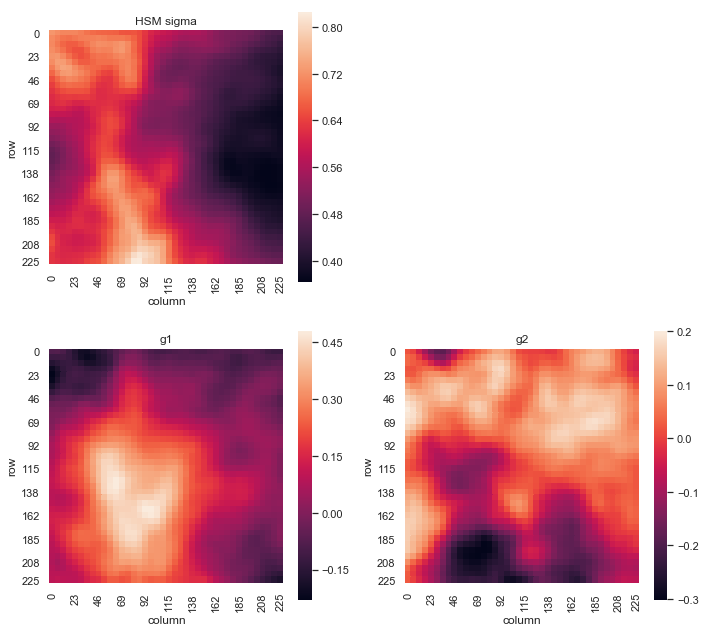

In [62]:
rng = np.random.RandomState(seed=28354)
noise_level = 0
variation_factor = 10
psf = PowerSpectrumPSF(
    rng=rng, im_width=225, buff=75, scale=0.25, trunc=1, 
    noise_level=noise_level,
    variation_factor=variation_factor)

n = 40
func = lambda x,y: psf.getPSF(galsim.PositionD(x=x, y=y))

fwhm, g1, g2 = _get_psf_variation(func, n=n)

_plot_psf_variation(fwhm, g1, g2, n=n)


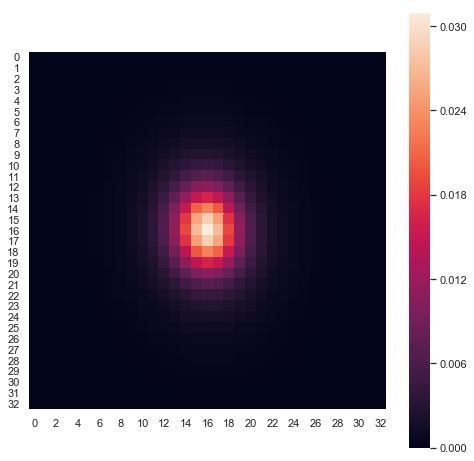

In [63]:
plt.figure(figsize=(8, 8))
psf_im = psf.getPSF(galsim.PositionD(x=10, y=10)).drawImage(scale=0.25, nx=33, ny=33).array
sns.heatmap(psf_im, square=True)

In [64]:
nse = np.std(psf_im[-1, :])
print(np.sqrt(np.sum(psf_im**2) / noise_level**2))
print(np.sqrt(np.sum(psf_im**2) / nse**2))

inf
3722.1085066266764


/Users/Matt/miniconda3/envs/anl/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
